### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization

from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Using TensorFlow backend.
C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sneha chikhalekar\Anaconda3\lib\sit

In [5]:
df=pd.read_csv("BackOrders.csv")

In [6]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


In [7]:
df.drop('sku',axis=1,inplace=True)

In [8]:
df=df.dropna()

In [13]:
df.dtypes

national_inv               int64
lead_time                float64
in_transit_qty             int64
forecast_3_month           int64
forecast_6_month           int64
forecast_9_month           int64
sales_1_month              int64
sales_3_month              int64
sales_6_month              int64
sales_9_month              int64
min_bank                   int64
pieces_past_due            int64
perf_6_month_avg         float64
perf_12_month_avg        float64
local_bo_qty               int64
potential_issue_Yes        uint8
deck_risk_Yes              uint8
oe_constraint_Yes          uint8
ppap_risk_Yes              uint8
stop_auto_buy_Yes          uint8
rev_stop_Yes               uint8
went_on_backorder_Yes      uint8
dtype: object

In [10]:
cat_cols=['potential_issue','deck_risk','oe_constraint','ppap_risk',
          'stop_auto_buy','rev_stop','went_on_backorder']
df[cat_cols]=df[cat_cols].astype('category')

In [12]:
df=pd.get_dummies(df,drop_first=True)

In [14]:
X=df.drop('went_on_backorder_Yes',axis=1)
y=df['went_on_backorder_Yes']

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1234)

In [18]:
print(X_train.shape)
print(X_test.shape)

(43639, 21)
(14547, 21)


### Model Building

#### Model with Relu as activation in hidden layer, Adam optimizer, Modified Xavier

In [19]:
np.random.seed(123)

In [28]:
def model_def(h_activation,o_activation,kernel_init):
    
    model=Sequential()
    
    model.add(Dense(25,input_dim=21,activation=h_activation,kernel_initializer=kernel_init))
    model.add(Dense(15,activation=h_activation,kernel_initializer=kernel_init))
    model.add(Dense(1,activation=o_activation,kernel_initializer=kernel_init))
    
    return model


In [29]:
relu_model=model_def(h_activation='relu', o_activation='sigmoid', kernel_init='glorot_normal')

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
relu_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
relu_model_history = relu_model.fit(X_train, y_train, epochs=10,
                                    batch_size= 64,
                                    validation_split=0.2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 34911 samples, validate on 8728 samples
Epoch 1/10
34911/34911 [==============================] - 2s 71us/step - loss: 0.6775 - accuracy: 0.8397 - val_loss: 0.3824 - val_accuracy: 0.8795
Epoch 2/10
34911/34911 [==============================] - 1s 42us/step - loss: 0.3939 - accuracy: 0.8833 - val_loss: 0.3950 - val_accuracy: 0.8858
Epoch 3/10
34911/34911 [==============================] - 1s 41us/step - loss: 0.4338 - accuracy: 0.8800 - val_loss: 0.3406 - val_accuracy: 0.8956
Epoch 4/10
34911/34911 [==============================] - 1s 40us/step - loss: 0.3433 - accuracy: 0.8954 - val_loss: 0.3352 - val_accuracy: 0.8969
Epoch 5/10
34911/34911 [==============================] - 1s 34us/step - loss: 0.3519 - accuracy: 0.8939 - val_loss: 0.3647 - val_accuracy: 0.8934
Epoch 6/10
34911/34911 [==============================] - 1s 34us/step - loss: 0.3918 - accuracy: 0.8887 - val_loss: 0.3296 - val_accuracy: 0.8952
Epoch 7/10
34911/3491

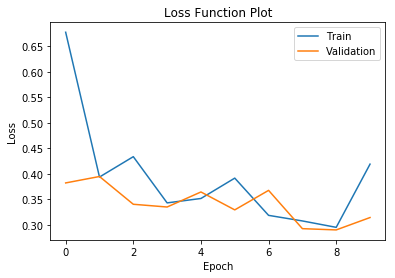

In [32]:
plt.plot(relu_model.history.history['loss'])
plt.plot(relu_model.history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
train_relu_model_pred = relu_model.predict_classes(X_train)
test_relu_model_pred = relu_model.predict_classes(X_test)

In [34]:
confusion_matrix_train = confusion_matrix(y_train, train_relu_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_relu_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[33117  2255]
 [ 2149  6118]]
[[11102   743]
 [  669  2033]]


In [35]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.936249010516793
Train TPR:  0.7400508044030483
Train Accuracy:  0.8990810971837118
-----------------------
Test TNR:  0.9372731110173069
Test TPR:  0.7524056254626202
Test Accuracy:  0.9029353131229807


#### Model with Dropout

In [36]:
dropout_model=Sequential()

In [37]:
dropout_model.add(Dense(25,input_dim=21,activation='relu',kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(15,activation='relu',kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(1,activation='sigmoid',kernel_initializer="glorot_normal"))


In [38]:
dropout_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [39]:
dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
dropout_model_history = dropout_model.fit(X_train, y_train, epochs=10,
                                          batch_size=64, 
                                          validation_split=0.2, shuffle=True)

Train on 34911 samples, validate on 8728 samples
Epoch 1/10
34911/34911 [==============================] - 3s 77us/step - loss: 1.0306 - accuracy: 0.8292 - val_loss: 0.6907 - val_accuracy: 0.8668
Epoch 2/10
34911/34911 [==============================] - 2s 50us/step - loss: 0.6326 - accuracy: 0.8602 - val_loss: 0.3767 - val_accuracy: 0.8944
Epoch 3/10
34911/34911 [==============================] - 2s 50us/step - loss: 0.4958 - accuracy: 0.8635 - val_loss: 0.3403 - val_accuracy: 0.8670
Epoch 4/10
34911/34911 [==============================] - 2s 43us/step - loss: 0.3896 - accuracy: 0.8561 - val_loss: 0.3157 - val_accuracy: 0.8718
Epoch 5/10
34911/34911 [==============================] - 1s 43us/step - loss: 0.3559 - accuracy: 0.8587 - val_loss: 0.3042 - val_accuracy: 0.8720
Epoch 6/10
34911/34911 [==============================] - 2s 43us/step - loss: 0.3328 - accuracy: 0.8705 - val_loss: 0.2916 - val_accuracy: 0.8871
Epoch 7/10
34911/34911 [==============================] - 2s 44us/ste

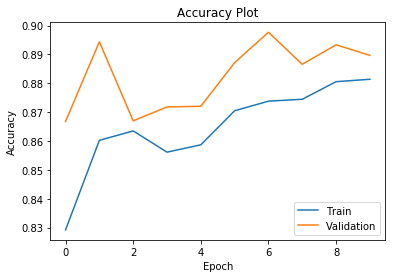

In [48]:
plt.plot(dropout_model_history.history['accuracy'])
plt.plot(dropout_model_history.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

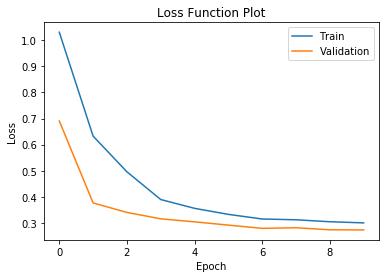

In [49]:
plt.plot(dropout_model_history.history['loss'])
plt.plot(dropout_model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [50]:
train_dropout_model_pred = dropout_model.predict_classes(X_train)
test_dropout_model_pred = dropout_model.predict_classes(X_test)

In [51]:
confusion_matrix_train = confusion_matrix(y_train, train_dropout_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_dropout_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32496  2876]
 [ 1965  6302]]
[[10929   916]
 [  615  2087]]


In [52]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9186927513287346
Train TPR:  0.762307971452764
Train Accuracy:  0.8890671188615688
-----------------------
Test TNR:  0.9226677923174336
Test TPR:  0.7723908216136195
Test Accuracy:  0.8947549322884444


#### Model with Batch Normalization

In [53]:
### We can do normalization before or after activation made

In [54]:
np.random.seed(123)
from keras.layers import Activation

In [56]:
bn_model=Sequential()

bn_model.add(Dense(25,input_dim=21,activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())

bn_model.add(Dense(15,kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Activation('relu'))

bn_model.add(Dense(1,activation='sigmoid',kernel_initializer="glorot_normal"))


In [57]:
bn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 25)                550       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_9 (Dense)              (None, 15)                390       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
activation_1 (Activation)    (None, 15)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
Total params: 1,116
Trainable params: 1,036
Non-trainable params: 80
___________________________________________________

In [58]:
bn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
bn_model_history = bn_model.fit(X_train, y_train, epochs=10,
                                batch_size=64, validation_split=0.2)

Train on 34911 samples, validate on 8728 samples
Epoch 1/10
34911/34911 [==============================] - 4s 102us/step - loss: 0.3951 - accuracy: 0.8274 - val_loss: 0.4152 - val_accuracy: 0.8135
Epoch 2/10
34911/34911 [==============================] - 2s 59us/step - loss: 0.3064 - accuracy: 0.8639 - val_loss: 0.3888 - val_accuracy: 0.8175
Epoch 3/10
34911/34911 [==============================] - 2s 65us/step - loss: 0.2959 - accuracy: 0.8719 - val_loss: 0.3901 - val_accuracy: 0.8154
Epoch 4/10
34911/34911 [==============================] - 2s 56us/step - loss: 0.2863 - accuracy: 0.8768 - val_loss: 0.3788 - val_accuracy: 0.8201
Epoch 5/10
34911/34911 [==============================] - 2s 57us/step - loss: 0.2830 - accuracy: 0.8790 - val_loss: 0.3803 - val_accuracy: 0.8181
Epoch 6/10
34911/34911 [==============================] - 2s 64us/step - loss: 0.2809 - accuracy: 0.8810 - val_loss: 0.3682 - val_accuracy: 0.8226
Epoch 7/10
34911/34911 [==============================] - 2s 57us/st

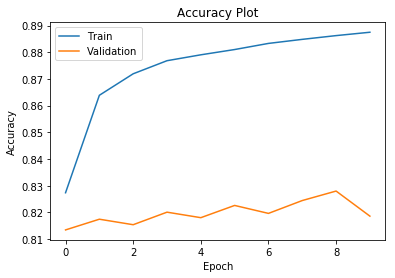

In [63]:
plt.plot(bn_model.history.history['accuracy'])
plt.plot(bn_model.history.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

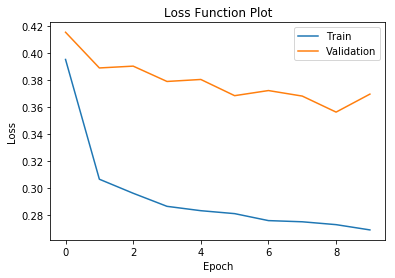

In [64]:
plt.plot(bn_model.history.history['loss'])
plt.plot(bn_model.history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [65]:
train_bn_model_pred = bn_model.predict_classes(X_train)
test_bn_model_pred = bn_model.predict_classes(X_test)

In [66]:
confusion_matrix_train = confusion_matrix(y_train, train_bn_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bn_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[35267   105]
 [ 7827   440]]
[[11817    28]
 [ 2574   128]]


In [67]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9970315503788307
Train TPR:  0.05322366033627676
Train Accuracy:  0.8182359815761131
-----------------------
Test TNR:  0.9976361333896159
Test TPR:  0.047372316802368614
Test Accuracy:  0.8211315047776174


#### Model with Weight decay

In [75]:
weight_decay_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [78]:
def l2_model_func(l2_value):
    
    l2_model=Sequential()
    
    l2_model.add(Dense(25,input_dim=21,activation='relu',kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(l2_value), kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))

    l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return l2_model


In [79]:
hist_loss=[]

for weight_decay in weight_decay_list:
    
    l2_model = l2_model_func(weight_decay)
    
    #Fit the model
    l2_model_history = l2_model.fit(X_train, y_train, epochs=1,
                                    validation_split=0.2, steps_per_epoch=50,
                                    validation_steps=50)
    
    hist_loss.append(l2_model_history.history['loss'])

Train on 34911 samples, validate on 8728 samples
Epoch 1/1
50/50 [==============================] - 7s 134ms/step - loss: 5.4806 - accuracy: 0.7704 - val_loss: 0.0770 - val_accuracy: 41.6189
Train on 34911 samples, validate on 8728 samples
Epoch 1/1
50/50 [==============================] - 6s 129ms/step - loss: 3.7827 - accuracy: 0.5828 - val_loss: 0.0294 - val_accuracy: 40.5706
Train on 34911 samples, validate on 8728 samples
Epoch 1/1
50/50 [==============================] - 7s 133ms/step - loss: 2.1753 - accuracy: 0.7311 - val_loss: 0.0293 - val_accuracy: 40.5362
Train on 34911 samples, validate on 8728 samples
Epoch 1/1
50/50 [==============================] - 6s 128ms/step - loss: 3.4950 - accuracy: 0.5361 - val_loss: 0.0333 - val_accuracy: 40.5591
Train on 34911 samples, validate on 8728 samples
Epoch 1/1
50/50 [==============================] - 7s 130ms/step - loss: 2.2908 - accuracy: 0.6985 - val_loss: 0.0209 - val_accuracy: 40.9888
Train on 34911 samples, validate on 8728 samp

In [88]:
# Get the weight decay and loss df

loss_weight_decay=pd.DataFrame([weight_decay_list,hist_loss]).T

loss_weight_decay.columns=['weight_decay','loss']

# Sort values and reset the index

loss_weight_decay=loss_weight_decay.sort_values('loss').reset_index().drop('index',axis=1)


In [89]:
loss_weight_decay

,weight_decay,loss
0,0.001,[2.1753185248374938]
1,1e-05,[2.290828251838684]
2,1e-06,[2.7918812322616575]
3,0.0001,[3.4950021171569823]
4,0.01,[3.782650270462036]
5,0.1,[5.48063362121582]


In [90]:
## Build model on best one

In [91]:
bst_l2_model = Sequential()

bst_l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(0.001),kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(0.001), kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(0.001), kernel_initializer="glorot_normal"))

# Compile model
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
bst_l2_model_history = bst_l2_model.fit(X_train, y_train, epochs=10,
                                        batch_size=64, 
                                        validation_split=0.2, shuffle=True)

Train on 34911 samples, validate on 8728 samples
Epoch 1/10
34911/34911 [==============================] - 3s 79us/step - loss: 1.7161 - accuracy: 0.7767 - val_loss: 0.5693 - val_accuracy: 0.8643
Epoch 2/10
34911/34911 [==============================] - 2s 57us/step - loss: 0.8467 - accuracy: 0.8217 - val_loss: 0.4185 - val_accuracy: 0.8167
Epoch 3/10
34911/34911 [==============================] - 2s 59us/step - loss: 0.5558 - accuracy: 0.8162 - val_loss: 0.3813 - val_accuracy: 0.8128
Epoch 4/10
34911/34911 [==============================] - 2s 62us/step - loss: 0.4656 - accuracy: 0.8170 - val_loss: 0.3713 - val_accuracy: 0.8122
Epoch 5/10
34911/34911 [==============================] - 2s 55us/step - loss: 0.4412 - accuracy: 0.8122 - val_loss: 0.3616 - val_accuracy: 0.8115
Epoch 6/10
34911/34911 [==============================] - 2s 53us/step - loss: 0.4155 - accuracy: 0.8124 - val_loss: 0.3540 - val_accuracy: 0.8112
Epoch 7/10
34911/34911 [==============================] - 2s 52us/ste

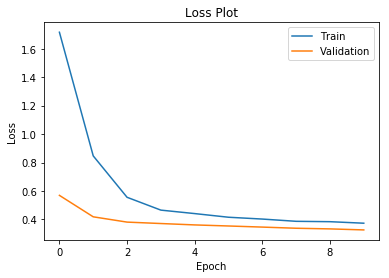

In [93]:
plt.plot(bst_l2_model.history.history['loss'])
plt.plot(bst_l2_model.history.history['val_loss'])

plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [94]:
train_bst_l2_model_pred = bst_l2_model.predict_classes(X_train)
test_bst_l2_model_pred = bst_l2_model.predict_classes(X_test)

In [95]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_l2_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_l2_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[35348    24]
 [ 8123   144]]
[[11838     7]
 [ 2654    48]]


In [96]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9993214972294471
Train TPR:  0.017418652473690576
Train Accuracy:  0.8133091959027475
-----------------------
Test TNR:  0.9994090333474039
Test TPR:  0.01776461880088823
Test Accuracy:  0.8170756857083935
